In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image, ImageChops, ImageEnhance
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    precision_score, 
    recall_score, 
    f1_score, 
    accuracy_score
)

In [2]:

class ForgeryDetector:
    def __init__(self, dataset_path):
        """
        Initialize Forgery Detector
        """
        self.dataset_path = dataset_path
        self.model = None
        self.history = None
    
    def gaussian_blur_difference(self, image_path):
        """
        Calculate difference image using Gaussian Blur
        """
        original_image = cv2.imread(image_path)
        gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        diff = cv2.absdiff(gray, blurred)
        diff_color = cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)
        return diff_color

    def error_level_analysis(self, image_path, quality=90):
        """
        Perform Error Level Analysis
        """
        try:
            original = Image.open(image_path)
            temp_compressed = 'temp_compressed.jpg'
            original.save(temp_compressed, 'JPEG', quality=quality)
            compressed = Image.open(temp_compressed)
            ela_image = ImageChops.difference(original, compressed)
            ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
            os.remove(temp_compressed)
            ela_cv = cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
            return ela_cv
        except Exception as e:
            print(f"ELA Error: {e}")
            return None

    def preprocess_image(self, image_path):
        """
        Preprocess image with Gaussian Blur and ELA
        """
        gb_diff = self.gaussian_blur_difference(image_path)
        ela_image = self.error_level_analysis(image_path)
        
        if ela_image is None:
            return None
        
        gb_resized = cv2.resize(gb_diff, (224, 224))
        ela_resized = cv2.resize(ela_image, (224, 224))
        
        combined = cv2.addWeighted(gb_resized, 0.2, ela_resized, 0.8, 0)
        return combined

    def prepare_dataset(self):
        """
        Prepare dataset with preprocessing
        """
        X, y = [], []
        
        # Process non-forged images
        non_forged_path = os.path.join(self.dataset_path, 'Au')
        for img_file in os.listdir(non_forged_path):
            if not img_file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                continue
            img_path = os.path.join(non_forged_path, img_file)
            processed_img = self.preprocess_image(img_path)
            
            if processed_img is not None:
                X.append(processed_img)
                y.append(0)  # Non-forged
        
        # Process forged images
        forged_path = os.path.join(self.dataset_path, 'Tp')
        for img_file in os.listdir(forged_path):
            if not img_file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                continue
            img_path = os.path.join(forged_path, img_file)
            processed_img = self.preprocess_image(img_path)
            
            if processed_img is not None:
                X.append(processed_img)
                y.append(1)  # Forged
        
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        return X, y

    def build_model(self):
        """
        Build MobileNetV2 model for forgery detection
        """
        base_model = MobileNetV2(
            weights='imagenet', 
            include_top=False, 
            input_shape=(224, 224, 3)
        )
        
        base_model.trainable = False
        
        x = base_model.output
        x = Flatten()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)


        output = Dense(1, activation='sigmoid')(x)
        
        self.model = Model(inputs=base_model.input, outputs=output)
        
        self.model.compile(
            optimizer=Adam(learning_rate=1e-4),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return self.model

    def train_model(self, X, y):
        """
        Train the model and return train/test split
        """
        # Preprocess input
        X = preprocess_input(X)
        
        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        
        # Train model
        self.history = self.model.fit(
            X_train, y_train,
            validation_split=0.25,
            epochs=30,
            batch_size=32
        )
        
        return X_train, X_test, y_train, y_test

    def plot_training_curves(self):
        """
        Plot accuracy and loss curves
        """
        plt.figure(figsize=(12, 4))
        
        # Accuracy subplot
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Loss subplot
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.show()

    def evaluate_model(self, X_test, y_test):
        """
        Comprehensive model evaluation
        """
        # Predict
        y_pred = (self.model.predict(X_test) > 0.5).astype(int).flatten()
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Print detailed classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Non-Forged', 'Forged'],
                    yticklabels=['Non-Forged', 'Forged'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()
        
        # Return metrics
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }


In [3]:
# Dataset path
dataset_path = r"./CASIA22"

# Initialize detector
detector = ForgeryDetector(dataset_path)

# Prepare dataset
X, y = detector.prepare_dataset()

# Build model
model = detector.build_model()






In [4]:

# Train model
X_train, X_test, y_train, y_test = detector.train_model(X, y)

Epoch 1/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 207s 921ms/step - accuracy: 0.6976 - loss: 1.1122 - val_accuracy: 0.7941 - val_loss: 0.4281
Epoch 2/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 198s 897ms/step - accuracy: 0.8016 - loss: 0.4553 - val_accuracy: 0.8306 - val_loss: 0.3928
Epoch 3/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 196s 885ms/step - accuracy: 0.8302 - loss: 0.3895 - val_accuracy: 0.8391 - val_loss: 0.3827
Epoch 4/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 195s 884ms/step - accuracy: 0.8488 - loss: 0.3498 - val_accuracy: 0.8352 - val_loss: 0.3747
Epoch 5/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 198s 895ms/step - accuracy: 0.8738 - loss: 0.2967 - val_accuracy: 0.8386 - val_loss: 0.3834
Epoch 6/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 196s 886ms/step - accuracy: 0.8814 - loss: 0.2896 - val_accuracy: 0.8429 - val_loss: 0.4035
Epoch 7/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 195s 884ms/step - accuracy: 0.9018 - loss: 0.2484 - val_accuracy: 0.8225 - val_loss: 0.4390
Epoch 8/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 194s 875ms/step - accuracy: 0.9073 -

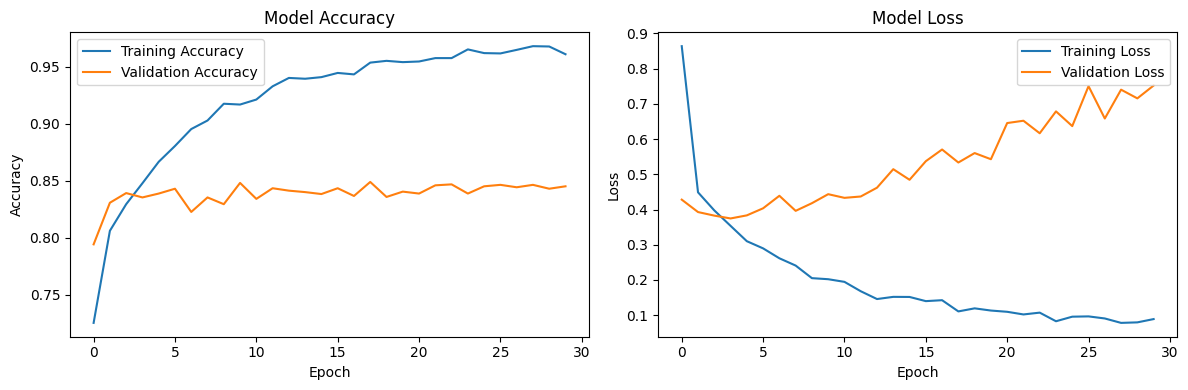

99/99 ━━━━━━━━━━━━━━━━━━━━ 44s 437ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1864
           1       0.78      0.85      0.81      1276

    accuracy                           0.84      3140
   macro avg       0.83      0.84      0.84      3140
weighted avg       0.85      0.84      0.84      3140



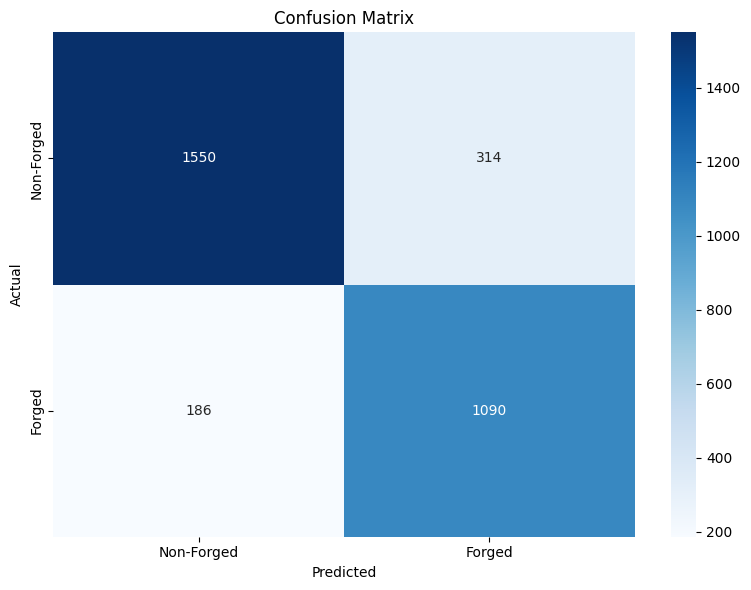


Model Performance Metrics:
Accuracy: 0.8408
Precision: 0.7764
Recall: 0.8542
F1_score: 0.8134


In [5]:
# Plot training curves
detector.plot_training_curves()

# Evaluate model
metrics = detector.evaluate_model(X_test, y_test)

# Print metrics
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Save model
# detector.model.save('forgery_detection_model.h5')